In [1]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.optim as optim
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
import random as rn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'archive/flowers'

In [14]:
data = ImageFolder(path, transform=transform.Compose([
                                 transform.Resize((220, 220)),
                                 transform.ToTensor(),
                                 transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178),
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
]))
invTrans = transform.Compose([ transform.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.3268945515155792, 1/0.29282665252685547, 1/0.29053378105163574 ]),
                                transform.Normalize(mean = [ -0.4124234616756439, -0.3674212694168091, -0.2578217089176178 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [4]:
batch_size = 32
seed = 42
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=seed)

In [5]:
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip')

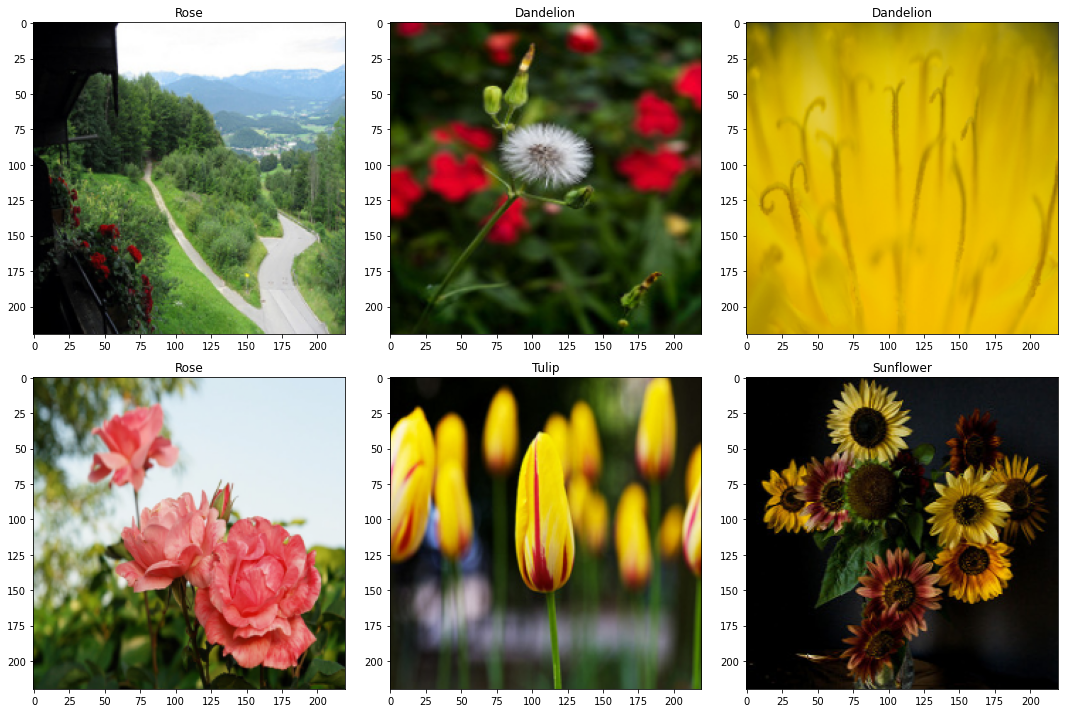

In [16]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,10)
img,y = iter(trainloader).next()
img = invTrans(img)
for i in range(2):
    for j in range (3):
        l=rn.randint(0,31)
        # label = list(train_dataset.class_indices.keys())[np.argmax(y[l])]
        npimg = img[l].numpy()
        ax[i,j].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[i,j].set_title(classes[y[l]])

plt.tight_layout()

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(43264, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(i)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [28]:
PATH = './flower_adam_2cn3l_net.pth'
torch.save(net.state_dict(), PATH)

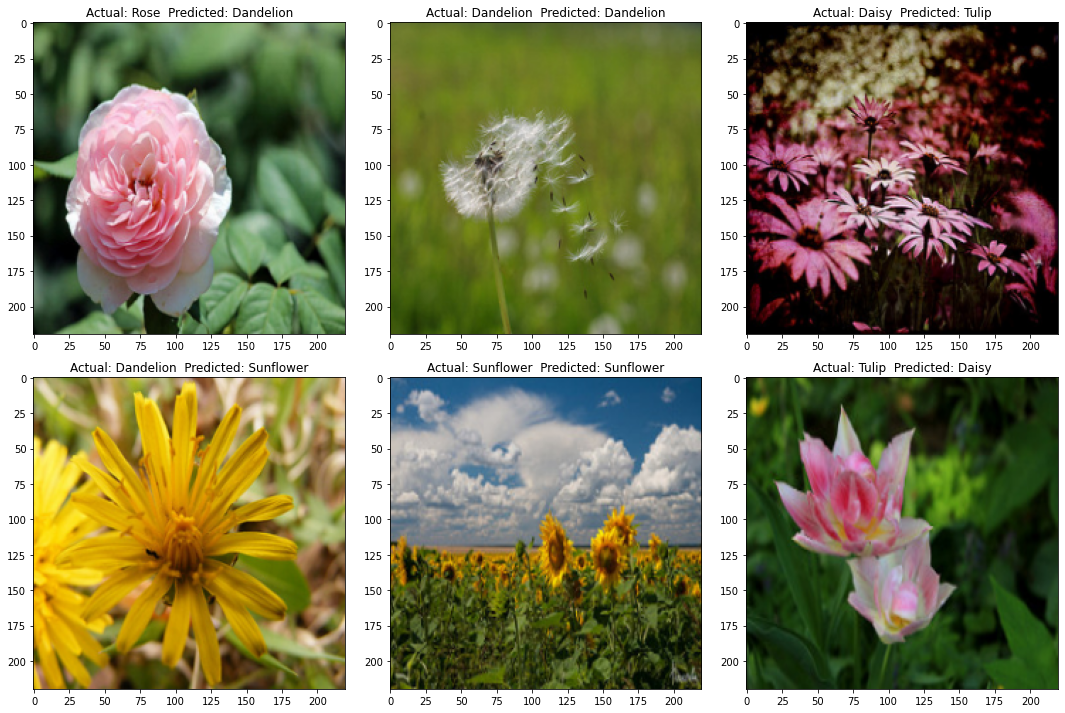

In [35]:
net = Net()
net.load_state_dict(torch.load(PATH))

# dataiter = iter(testloader)
# images, y = dataiter.next()
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,10)
img,y = iter(testloader).next()
outputs = net(img)
_, pred= torch.max(outputs, 1)
img = invTrans(img)
for i in range(2):
    for j in range (3):
        l=rn.randint(0,31)
        # label = list(train_dataset.class_indices.keys())[np.argmax(y[l])]
        npimg = img[l].numpy()
        ax[i,j].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[i,j].set_title('Actual: '+classes[y[l]]+'  Predicted: '+classes[pred[l]])

plt.tight_layout()
# print images

In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 57 %


In [ ]:

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
